In [1]:
! pip install zfpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.utils.prune as prune
import torchvision.models as models
from torchvision.models import VGG11_Weights
import numpy as np
import zfpy
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tabulate import tabulate
import pandas as pd
import pickle
import os
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import json
from io import StringIO


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
TRAIN = False
PRUNE = True
PRUNE_LOAD = False
TRAIN_LOAD = False
TEST_JSON = 'test_data.json'
PRUNE_DATA_JSON = 'prune_data.json'
MODEL_PATH = '/kaggle/input/190-tolerance/org_model.pkl'

### Helper Functions

In [4]:
def print_statistics(model):
    all_statistics = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.flatten()
            statistics = {
                'Layer': name,
                'Mean': weights.mean().item(),
                'Standard Deviation': weights.std().item(),
                'Min': weights.min().item(),
                'Max': weights.max().item()
            }
            all_statistics.append(statistics)
    
    df = pd.DataFrame(all_statistics)
    return df

In [5]:
def plot_weight_distribution(model, tolerance=1e-3, base=False, prune=-1, prune_zfp=False, bins=100):
    model = model.cpu()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    if base:
        fig.suptitle(f'Weight Distribution of Original Feature Weights')
    elif prune > -1:
        if prune_zfp:
            fig.suptitle(f'Weight Distribution of Feature Weights (ZFP {100*prune} pruned) (Tolerance {tolerance})')
        else:
            fig.suptitle(f'Weight Distribution of Feature Weights (Base {100*prune} pruned) (Tolerance {tolerance})')
    else:
        fig.suptitle(f'Weight Distribution of only Feature Weights (Tolerance {tolerance})')

    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    
    with pd.option_context('mode.use_inf_as_na', True):
        i = 0
        for name, param in model.named_parameters():
            if 'weight' in name and 'features' in name:
                weights = param.data.flatten()

                # Plot histogram for this layer
                ax = axes[i//4, i%4]
                sns.histplot(weights, bins=bins, kde=True, ax=ax)
                ax.set_title(f'{name}')
                ax.set_xlabel('Weight Value')
                ax.set_ylabel('Frequency')
                ax.set_yscale('log')

                i += 1

In [6]:
# classifier.0.weight 102760448
# classifier.3.weight 16777216
# classifier.6.weight 4096000

def plot_classifier_distribution(model, tolerance=1e-3, base=False, prune=-1, prune_zfp=False, bins=100, classifier_num=6):
    model = model.cpu()
    plt.figure(figsize=(8, 6))
    
    layer_name = ''
    with pd.option_context('mode.use_inf_as_na', True):
        for name, param in model.named_parameters():
            if 'classifier' in name and str(classifier_num) in name:
                weights = param.data.flatten()

                # Plot histogram for this layer
                sns.histplot(weights, bins=bins, kde=True)
                layer_name = name
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.yscale('log')

                break
        
    if base:
        plt.title(f'Weight Distribution of {layer_name}')
    elif prune > -1:
        if prune_zfp:
            plt.title(f'Weight Distribution of {layer_name} (ZFP {100*prune} pruned) (Tolerance {tolerance})')
        else:
            plt.title(f'Weight Distribution of {layer_name} (Base {100*prune} pruned) (Tolerance {tolerance})')
    else:
        plt.title(f'Weight Distribution of {layer_name} (Tolerance {tolerance})')

    plt.show()

In [7]:
def compare_model_stats(model, copied_model):
    res = pd.DataFrame()
    res['Layer'] = model['Layer']
    res['MSE Mean'] = (model['Mean'] - copied_model['Mean'])**2
    res['MSE SD'] = (model['Standard Deviation'] - copied_model['Standard Deviation'])**2
    res['MSE Min'] = (model['Min'] - copied_model['Min'])**2
    res['MSE Max'] = (model['Max'] - copied_model['Max'])**2
    
    return res

In [8]:
def save_pkl(file: str, state_dict: dict) -> float:
    with open(file, 'wb') as f:
        pickle.dump(state_dict, f)
    return os.path.getsize(file)
        
def load_pkl(file: str) -> dict:
    with open(file, 'rb') as f:
        return pickle.load(f)

### Compress and Decompress functions using ZFP

In [9]:
# Function to compress tensor using ZFP
def compress_tensor(tensor, tolerance=1e-3):
    array = tensor.cpu().numpy()  # Convert tensor to numpy array
    compressed = zfpy.compress_numpy(array, tolerance=tolerance)
    return compressed

# Function to decompress tensor using ZFP
def decompress_tensor(compressed, original_shape):
    decompressed = zfpy.decompress_numpy(compressed)
    tensor = torch.tensor(decompressed).reshape(original_shape)
    return tensor

### Train VGG11

#### Dataset

In [10]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
      
    with pd.option_context('mode.use_inf_as_na', False):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
    
        if test:
            dataset = datasets.CIFAR100(
              root=data_dir, train=False,
              download=True, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR100(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)


# CIFAR100 dataset
if TRAIN:
    train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)
    
test_loader = data_loader(data_dir='./data',
                          batch_size=64,
                          test=True)

def test_accuracy(model):
    with torch.no_grad():
        correct = 0
        total = 0
        i = 0
        
#         return 100*3/5
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            
            i += 1
#             if i == 1:
#                 break
            
        return 100 * correct / total

/tmp/ipykernel_23/1903179062.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):


100%|██████████| 169001437/169001437 [00:15<00:00, 11134843.86it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


#### Training

In [11]:
if TRAIN:
    model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1).to(device)  
    num_epochs = 5
    learning_rate = 0.005

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
        
            print('Accuracy of the network on the {} validation images: {} % (Epoch {})'.format(5000, 100 * correct / total, epoch+1))
else:
#     model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1).to(device)  
    model = models.vgg11()
    model.load_state_dict(load_pkl(MODEL_PATH))
    model.eval()

### Distribution of Original Weights

In [12]:
# classifier.0.weight 102760448
# classifier.3.weight 16777216
# classifier.6.weight 4096000
# plot_weight_distribution(model, base=True)

In [13]:
orig_stats = print_statistics(model)
orig_stats

,Layer,Mean,Standard Deviation,Min,Max
0,features.0.weight,-6.118355e-04,0.182518,-0.576514,0.733067
1,features.3.weight,-7.280580e-04,0.031691,-0.366674,0.426103
2,features.6.weight,-5.120513e-04,0.017840,-0.239951,0.290745
3,features.8.weight,-9.444316e-04,0.014110,-0.204781,0.409000
4,features.11.weight,-5.817962e-04,0.011325,-0.171319,0.202021
5,features.13.weight,-1.003245e-03,0.008708,-0.144776,0.156960
6,features.16.weight,-5.544542e-04,0.009031,-0.161565,0.128053
7,features.18.weight,-1.142678e-03,0.008698,-0.103508,0.119273
8,classifier.0.weight,-1.109735e-04,0.002568,-0.024549,0.042916
9,classifier.3.weight,-2.723727e-04,0.004957,-0.030718,0.038001


In [14]:
model = model.to(device)

weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        weights[name] = param.data            
org_size = save_pkl('org_model_param_size.pkl', weights)

if TRAIN:
    save_pkl('org_model.pkl', model.state_dict())

org_data = {
    'tolerance': 0,
    'test_accuracy': test_accuracy(model),
    'compression_ratio': 1,
    'model_size': org_size / 1024**2,  # Size in MB
    'stats': orig_stats
}

print('Model Size:', org_data['model_size'], 'MB')
print(f'Test Accuracy: {org_data["test_accuracy"]}')

Model Size: 506.84027194976807 MB
Test Accuracy: 59.51


### Pruning

In [15]:
# parameters_to_prune = (
#     (model.features[0], 'weight'),
#     (model.features[3], 'weight'),
#     (model.features[6], 'weight'),
#     (model.features[8], 'weight'),
#     (model.features[11], 'weight'),
#     (model.features[13], 'weight'),
#     (model.features[16], 'weight'),
#     (model.features[18], 'weight')
# )

In [16]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        total_params += param.numel()
        zero_params += torch.sum(param == 0).item()

    sparsity = zero_params / total_params
    return sparsity

def global_prune(c_model, amount):
    parameters_to_prune = []
    
    for name, module in c_model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            parameters_to_prune.append((module, 'weight'))
            if module.bias is not None:
                parameters_to_prune.append((module, 'bias'))
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    for layer, param in parameters_to_prune:
        prune.remove(layer, param)
        
    
prune_values = [i/20 for i in range(0, 20)]
TOLERANCE = 0.0002  

if PRUNE and (TRAIN or not PRUNE_LOAD):
    prune_results = []
    for i, amount in tqdm(enumerate(prune_values), total=len(prune_values), desc="Processing", unit="item"):
        copied_model = copy.deepcopy(model)
        global_prune(copied_model, amount)
        before_sparisty = calculate_sparsity(copied_model)
        old_stats = print_statistics(copied_model)
        old_accuracy = test_accuracy(copied_model.to(device))
        
#         if i >= 17:
#             plot_classifier_distribution(copied_model, tolerance=TOLERANCE, prune=amount, prune_zfp=False, bins=100)

        # Compress weights
        compressed_weights = {}
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                compressed_weights[name] = compress_tensor(param.data, tolerance=TOLERANCE)

        pkl_path = f'zfp_model_prune_{amount}.pkl'
        zfp_size = save_pkl(pkl_path, compressed_weights)

        # Decompress weights
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                param.data = decompress_tensor(compressed_weights[name], param.data.shape)

#         if i >= 17:
#             plot_classifier_distribution(copied_model, tolerance=TOLERANCE, prune=amount, prune_zfp=True, bins=100)
        
        prune_results.append({
            'before_sparsity': before_sparisty,
            'after_sparsity': calculate_sparsity(copied_model),
            'compression_ratio': org_size / zfp_size,
            'model_size': zfp_size / 1024**2,  # Size in MB
            'old_stats': old_stats,
            'new_stats': print_statistics(copied_model),
            'before_accuracy': old_accuracy,
            'after_accuracy': test_accuracy(copied_model.to(device))
#             .to(device)
        })
    
    # save prune_results
    prune_results_copy = copy.deepcopy(prune_results)
    for r in prune_results_copy:
        r['old_stats'] = r['old_stats'].to_json(orient='records')
        r['new_stats'] = r['new_stats'].to_json(orient='records')
    
    with open(PRUNE_DATA_JSON, 'w') as json_file:
        json.dump(prune_results_copy, json_file, indent=4) 
        
elif PRUNE:
    # load prune_results
    with open(PRUNE_DATA_JSON, 'r') as json_file:
        prune_results = json.load(json_file)
        
        for r in prune_results:
            r['old_stats'] = pd.read_json(StringIO(r['old_stats']), orient='records')
            r['new_stats'] = pd.read_json(StringIO(r['new_stats']), orient='records')

Processing: 100%|██████████| 20/20 [21:35<00:00, 64.79s/item]


In [17]:
# plot_weight_distribution(copied_model, tolerance=TOLERANCE, prune=0.95, prune_zfp=False, bins=7)
# print(org_size)
# prune_results[0]

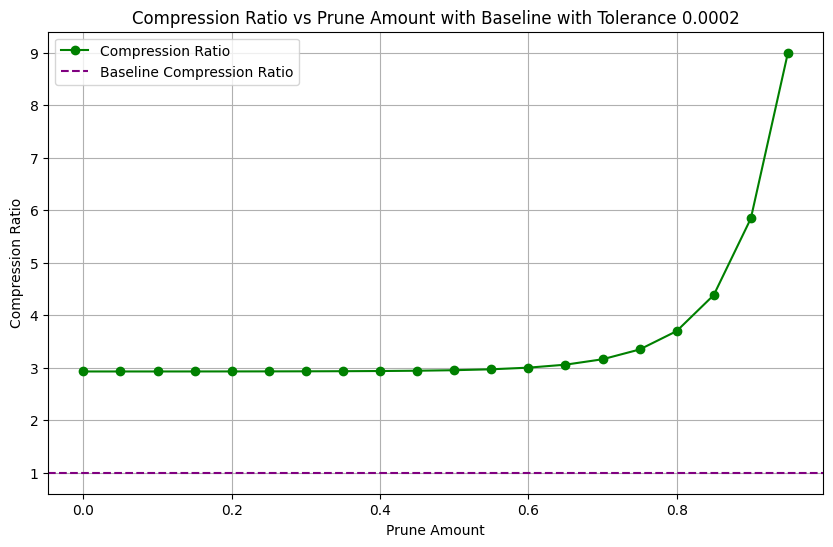

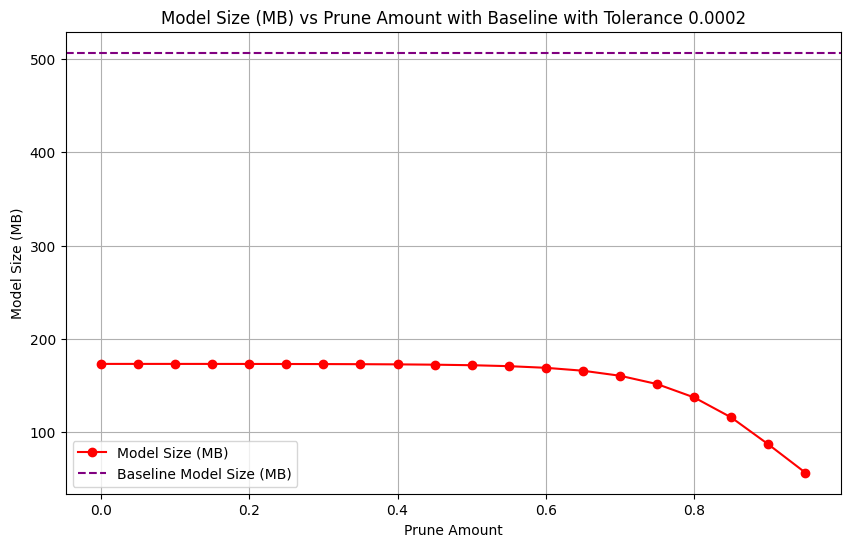

In [18]:
if PRUNE:
    compression_ratios = [result["compression_ratio"] for result in prune_results]
    model_sizes = [result["model_size"] for result in prune_results]
    

    data = [
        (compression_ratios, org_data['compression_ratio'], 'green', 'Compression Ratio'),
        (model_sizes, org_data['model_size'], 'red', 'Model Size (MB)'),
    ]

    for values, baseline, color, label in data:
        plt.figure(figsize=(10, 6))

        plt.plot(prune_values, values, color=color, marker='o', label=label)
        plt.axhline(y=baseline, color='purple', linestyle='--', label=f'Baseline {label}')

        plt.title(f'{label} vs Prune Amount with Baseline with Tolerance {TOLERANCE}')
#         plt.xscale('log', base=2)
        plt.xlabel('Prune Amount')
        plt.ylabel(label)
        plt.legend()
        plt.grid(True)

        plt.show()

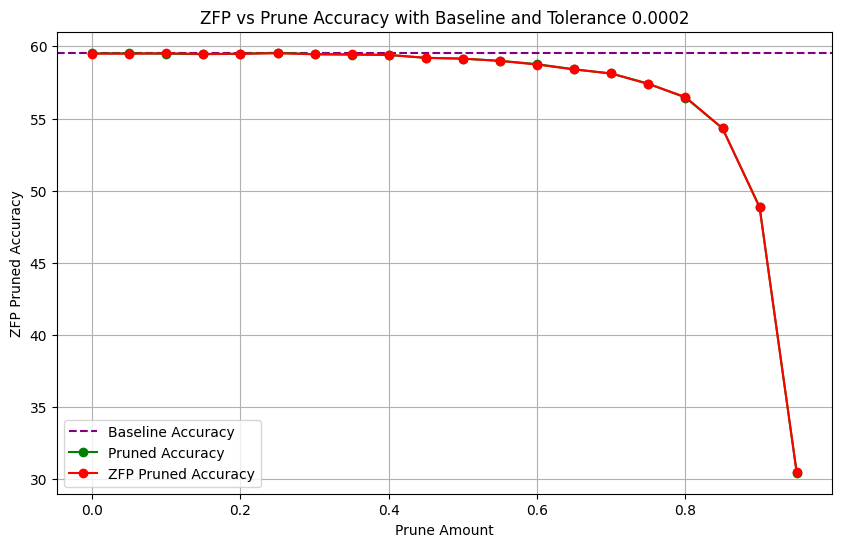

In [19]:
if PRUNE:
    before_accuracies = [result["before_accuracy"] for result in prune_results]
    after_accuracies = [result["after_accuracy"] for result in prune_results]
    baseline = org_data['test_accuracy']

    data = [
        (before_accuracies, 'green', 'Pruned Accuracy'),
        (after_accuracies,'red', 'ZFP Pruned Accuracy'),
    ]
    
    plt.figure(figsize=(10, 6))
    plt.axhline(y=baseline, color='purple', linestyle='--', label=f'Baseline Accuracy')

    for values, color, label in data:
        plt.plot(prune_values, values, color=color, marker='o', label=label)

    plt.title(f'ZFP vs Prune Accuracy with Baseline and Tolerance {TOLERANCE}')
    plt.xlabel('Prune Amount')
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)

    plt.show()
    
#     print(baseline, before_accuracies, after_accuracies)

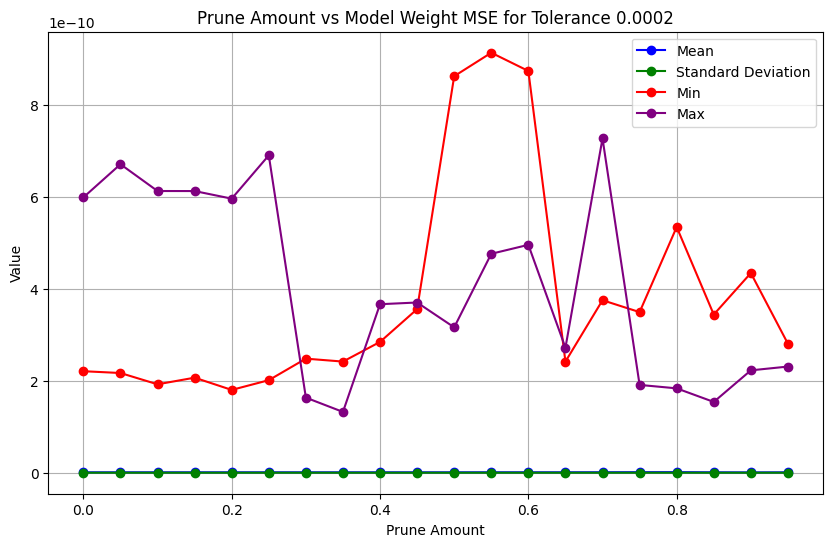

In [20]:
if PRUNE:
    avg_mean = []
    avg_sd = []
    avg_min = []
    avg_max = []
#     sparsity_dif = []

    for model_data in prune_results:
        comp = compare_model_stats(model_data['old_stats'], model_data['new_stats'])

        avg_mean.append(comp['MSE Mean'].sum())
        avg_sd.append(comp['MSE SD'].sum())  
        avg_min.append(comp['MSE Min'].sum())
        avg_max.append(comp['MSE Max'].sum())
#         sparsity_dif.append( (model_data['after_sparsity'] - model_data['before_sparsity'])**2 )
    
    data = [
        (avg_mean, 'blue', 'Mean'),
        (avg_sd, 'green', 'Standard Deviation'),
        (avg_min, 'red', 'Min'),
        (avg_max, 'purple', 'Max'),
#         (sparsity_dif, 'orange', 'Global Sparsity')
    ]

    plt.figure(figsize=(10, 6))
    plt.title(f'Prune Amount vs Model Weight MSE for Tolerance {TOLERANCE}')
    plt.xlabel('Prune Amount')
    plt.ylabel('Value')

    for values, color, label in data:
        plt.plot(prune_values, values, color=color, marker='o', label=label)

    plt.legend()
    plt.grid(True)
    plt.show()

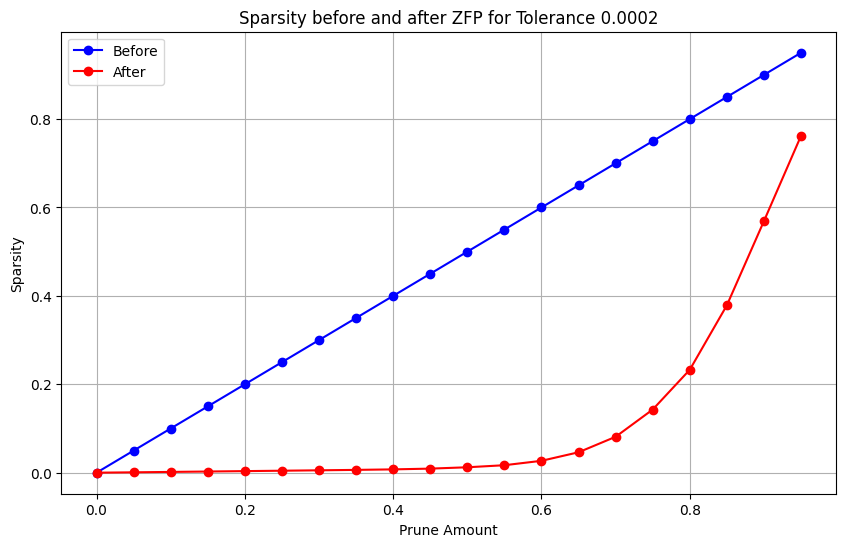

In [21]:
if PRUNE:    
    plt.figure(figsize=(10, 6))
    plt.title(f'Sparsity before and after ZFP for Tolerance {TOLERANCE}')
    plt.xlabel('Prune Amount')
    plt.ylabel('Sparsity')
    
    data = [
        ([r['before_sparsity'] for r in prune_results], 'blue', 'Before'),
        ([r['after_sparsity'] for r in prune_results], 'red', 'After'),
    ]
    for values, color, label in data:
        plt.plot(prune_values, values, color=color, marker='o', label=label)

    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
# print(prune_results[-4])

### Perform Test Accuracy

In [23]:
tolerance_values = [1/2**i for i in range(0, 27)]
# tolerance_values = [1/2**i for i in range(0, 2)]

if not PRUNE and (TRAIN or not TRAIN_LOAD):
    results = []

    for i, tolerance in tqdm(enumerate(tolerance_values), total=len(tolerance_values), desc="Processing", unit="item"):
        copied_model = copy.deepcopy(model)

        # Compress weights
        compressed_weights = {}
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                compressed_weights[name] = compress_tensor(param.data, tolerance=tolerance)

        pkl_path = f'zfp_model_{tolerance}.pkl'
        zfp_size = save_pkl(pkl_path, compressed_weights)

        # Decompress weights
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                param.data = decompress_tensor(compressed_weights[name], param.data.shape)
        
        results.append({
            'tolerance': tolerance,
            'test_accuracy': test_accuracy(copied_model.to(device)),
#             'test_accuracy': 0.25,
            'compression_ratio': org_size / zfp_size,
            'model_size': zfp_size / 1024**2,  # Size in MB
            'stats': print_statistics(copied_model)
        })

#         if i % 9 == 0:
#             plot_weight_distribution(copied_model, tolerance=tolerance)

### Save or Load Results

In [24]:
if not PRUNE:
    if TRAIN or not TRAIN_LOAD:
        # save results
        results_copy = copy.deepcopy(results)
        org_data_copy = copy.deepcopy(org_data)
        results_copy.append(org_data_copy)

        for r in results_copy:
            r['stats'] = r['stats'].to_json(orient='records')

        with open(TEST_JSON, 'w') as json_file:
            json.dump(results_copy, json_file, indent=4)  
    else:
        # load results
        with open(TEST_JSON, 'r') as json_file:
            results = json.load(json_file)

            for r in results:
                r['stats'] = pd.read_json(StringIO(r['stats']), orient='records')

            org_data = results.pop()

# print(results[0].keys())
# print(type(org_data['stats']))

### Graphing Tolerance vs Accuracy, Compression Ratio, Model Size

In [25]:
if not PRUNE:
    tolerances = [result["tolerance"] for result in results]
    accuracy = [result["test_accuracy"] for result in results]
    compression_ratios = [result["compression_ratio"] for result in results]
    model_sizes = [result["model_size"] for result in results]

    data = [
        (accuracy, org_data['test_accuracy'], 'blue', 'Test Accuracy'),
        (compression_ratios, org_data['compression_ratio'], 'green', 'Compression Ratio'),
        (model_sizes, org_data['model_size'], 'red', 'Model Size (MB)'),
    ]

    for values, baseline, color, label in data:
        plt.figure(figsize=(10, 6))

        plt.plot(tolerances, values, color=color, marker='o', label=label)
        plt.axhline(y=baseline, color='purple', linestyle='--', label=f'Baseline {label}')

        plt.title(f'{label} vs Tolerance (Log Scale) with Baseline')
        plt.xscale('log', base=2)
        plt.xlabel('Tolerance (Log Scale)')
        plt.ylabel(label)
        plt.legend()
        plt.grid(True)

        plt.show()

### Comparing Mean, Standard Deviation, Min, Max

In [26]:
if not PRUNE:

    abs_mean = []
    abs_sd = []
    abs_min = []
    abs_max = []
    orig_stats = org_data['stats']

    for tolerance, model_data in zip(tolerances, results):
        comp = compare_model_stats(orig_stats, model_data['stats'])

        abs_mean.append(comp['MSE Mean'].sum())
        abs_sd.append(comp['MSE SD'].sum())  
        abs_min.append(comp['MSE Min'].sum())
        abs_max.append(comp['MSE Max'].sum())
    
    
    # plotting
    data = [
        (abs_mean, 'blue', 'Mean'),
        (abs_sd, 'green', 'Standard Deviation'),
        (abs_min, 'red', 'Min'),
        (abs_max, 'purple', 'Max')
    ]

    plt.figure(figsize=(10, 6))
    plt.title(f'Tolerance vs Total Layer MSE for Mean, Standard Deviation, Min, and Max')
    plt.xscale('log', base=2)
    plt.xlabel('Tolerance (Log Scale)')
    plt.ylabel('Total MSE')

    for values, color, label in data:
        plt.plot(tolerances, values, color=color, marker='o', label=label)


    plt.legend()
    plt.grid(True)
    plt.show()

## Resources - Works Cited
- https://blog.paperspace.com/vgg-from-scratch-pytorch/
- https://pypi.org/project/zfpy/
- https://pytorch.org/hub/pytorch_vision_vgg/
- https://github.com/alex-grindrod/eblc-model-compression
- https://github.com/LLNL/zfp